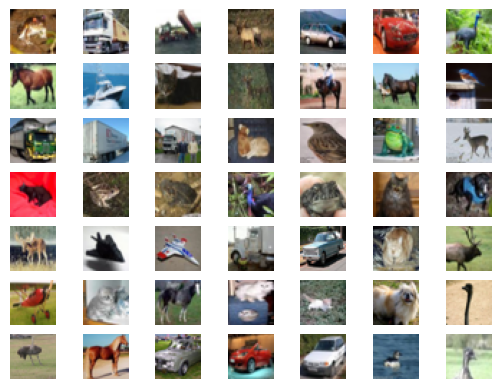

In [37]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
(trainX, trainy), (testX, testy) = load_data()


for i in range(49):
  pyplot.subplot(7, 7, 1+i)
  pyplot.axis('off')
  pyplot.imshow(trainX[i])
pyplot.show()

In [38]:
##Making Descrimator to indenfy AI generated model


from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model
import numpy as np


In [42]:
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()

  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))


  opt = Adam(learning_rate=0.002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [40]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()

  X = trainX.astype('float32')

  X = (X - 127.5) / 127.5
  return X


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_54 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,497 (1.99 MB)

 Trainable params: 522,497 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

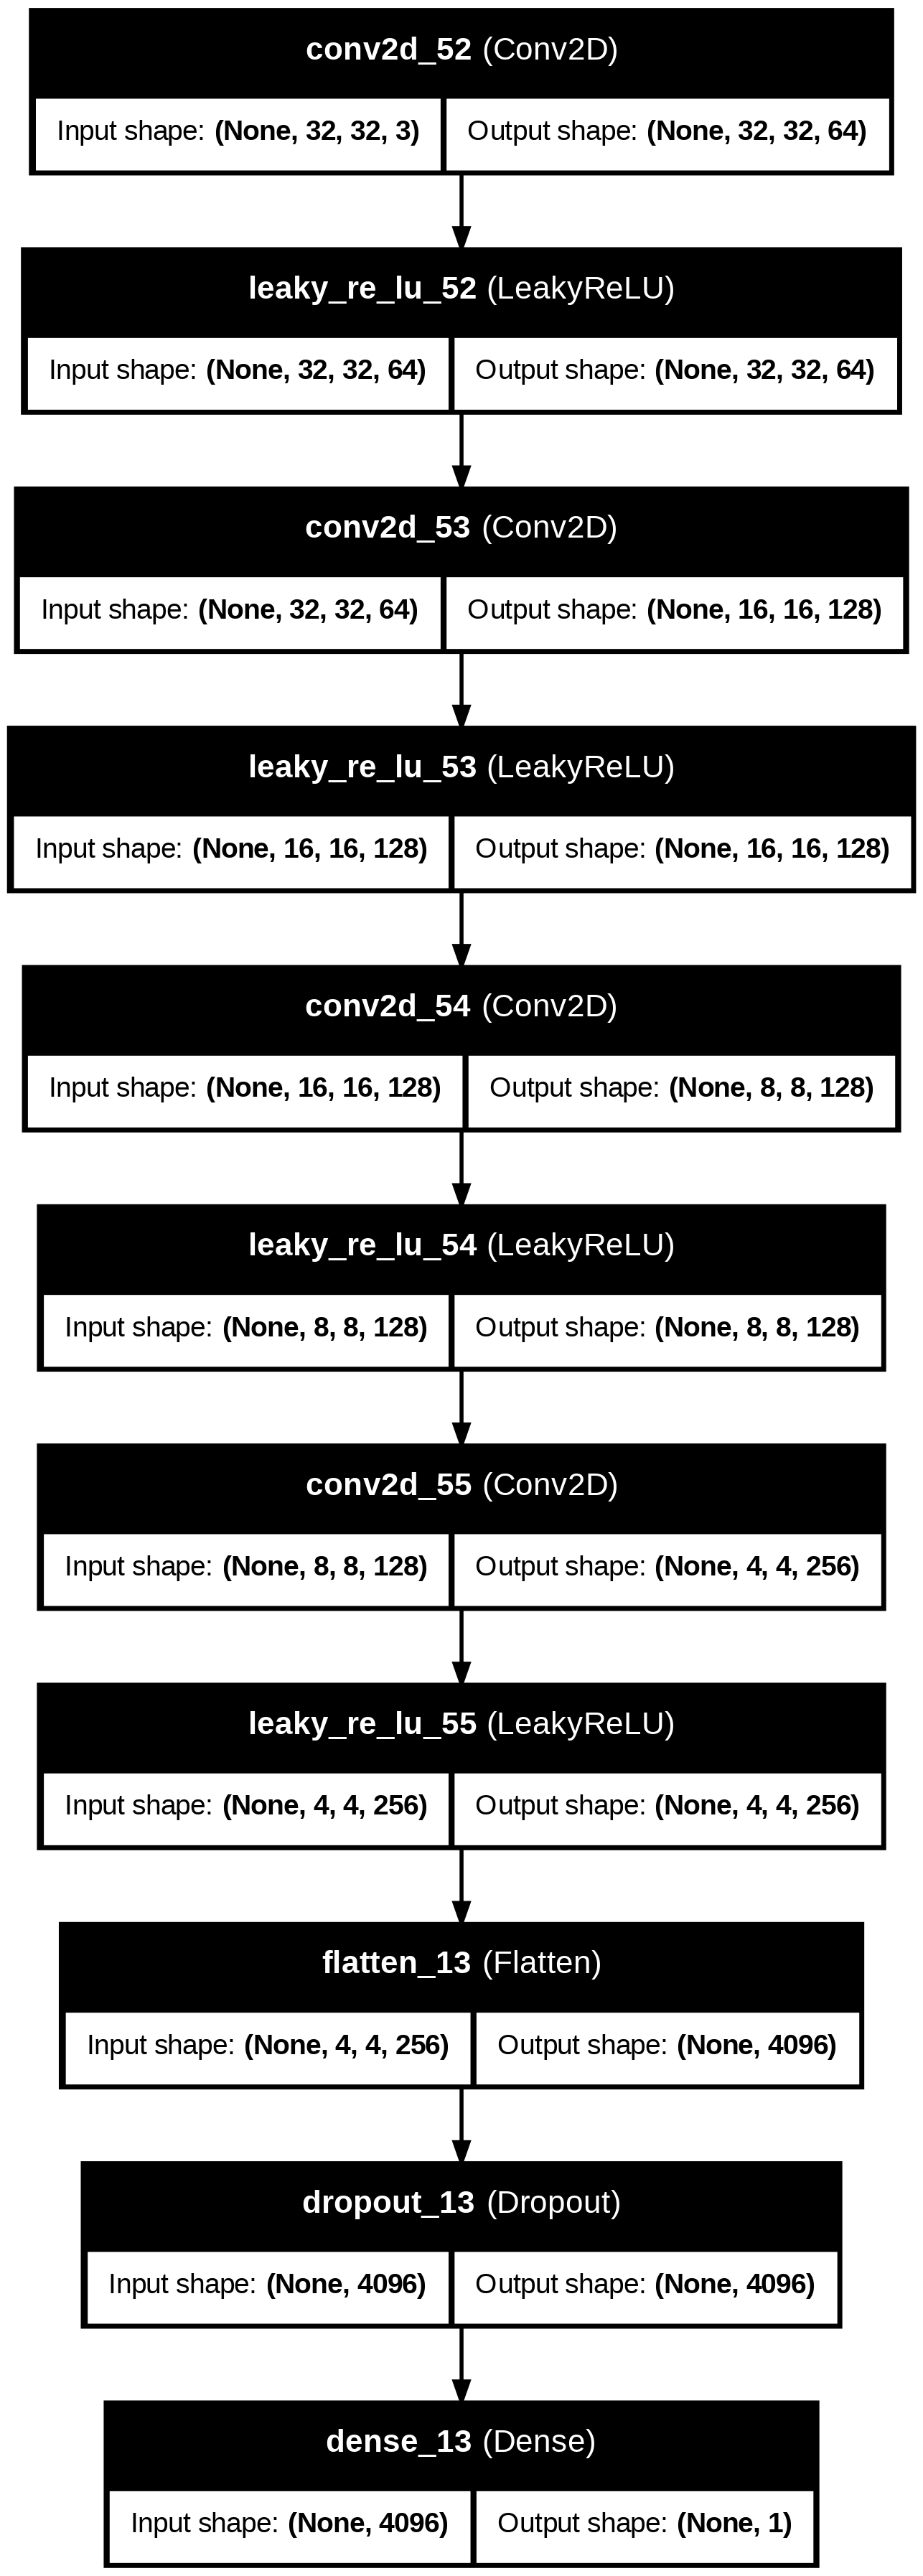

In [43]:
model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = trainX.astype('float32')
  X = (X - 127.5) / 127.5
  return X

In [51]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X, y

In [52]:
X,y = generate_real_samples(load_real_samples(), 64)
print(X.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [53]:
def generate_fake_samples(n_samples):
  X = np.random.randn(32 * 32 * 3 * n_samples)
  X = X.reshape((n_samples, 32, 32, 3))
  X = -1 + X * 2
  X = X.reshape((n_samples, 32, 32, 3))
  y = np.zeros((n_samples, 1))
  return X, y

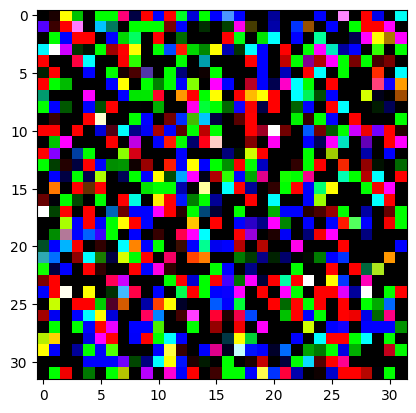

In [54]:
X,y = generate_fake_samples(64)
pyplot.imshow(X[0])

In [58]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch / 2)

  for i in range(n_iter):
    X_real, y_real = generate_real_samples(dataset, half_batch)
    _, real_acc = model.train_on_batch(X_real, y_real)

    X_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(X_fake, y_fake)

    print('>%d real=%0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [59]:
model = define_discriminator()


dataset = load_real_samples()

train_discriminator(model, dataset)

>1 real=17.187500% fake=9%
>2 real=5.729167% fake=20%
>3 real=19.687500% fake=33%
>4 real=32.366070% fake=41%
>5 real=44.618053% fake=50%
>6 real=53.551136% fake=57%
>7 real=60.336536% fake=63%
>8 real=65.000000% fake=67%
>9 real=69.117645% fake=71%
>10 real=72.368416% fake=74%
>11 real=74.776787% fake=76%
>12 real=76.834236% fake=78%
>13 real=78.625000% fake=79%
>14 real=80.208328% fake=81%
>15 real=81.573280% fake=82%
>16 real=82.762100% fake=83%
>17 real=83.806816% fake=84%
>18 real=84.732147% fake=85%
>19 real=85.557434% fake=86%
>20 real=86.298080% fake=87%
